# Feature search

We are looking for a feature that has the following properites:
* Predicted by presence of a single token with high precision and recall
* Minimal number of attention heads contributing to SAE feature

This is the plan:
* Let `DD := data/processed/gelu_1l_audit`
* Compute and store activations, logits, SAE features for all data points
    * Store in `DD/activations`
* Find (feature, token) pairs:
    * Take top K activations for each SAE feature
    * Take the top token in the dataset for these examples
    * Store in `DD/token_feature_pairs`
* Evaluate precision and recall of `FEATURE IF TOKEN` predictor
    * Store in `DD/precision_recall.tsv`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Some hyperparameters

MODEL = "gelu-1l"
RUN = "run1"
DD = f"../data/processed/{MODEL}_{RUN}_audit"

BATCH_SIZE = 128

In [51]:
pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 125.7 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 131.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [52]:
# Imports

import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from sprint.loading import load_all

from sklearn.metrics import f1_score

In [4]:
# Make sure DD exists

if not os.path.exists(DD):
    os.mkdir(DD)

In [5]:
# Load model, data, and SAE

model, data, sae = load_all(verbose=False)

Loaded pretrained model gelu-1l into HookedTransformer
Moving model to device:  cuda
Changing model dtype to torch.float16
{'batch_size': 4096,
 'beta1': 0.9,
 'beta2': 0.99,
 'buffer_batches': 12288,
 'buffer_mult': 384,
 'buffer_size': 1572864,
 'd_mlp': 2048,
 'dict_mult': 8,
 'enc_dtype': 'fp32',
 'l1_coeff': 0.0003,
 'lr': 0.0001,
 'model_batch_size': 512,
 'num_tokens': 2000000000,
 'seed': 52,
 'seq_len': 128}


## Brief detour: how to stash all of our activations conveniently

In [6]:
# Brief sanity check: how can we pull out all of the model components for a batch:

data_batch = data[:32, :]
logits_batch, cache_batch = model.run_with_cache(data_batch)

print(logits_batch.shape)
print(cache_batch.keys())
print(model)

torch.Size([32, 128, 48262])
dict_keys(['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'ln_final.hook_scale', 'ln_final.hook_normalized'])
HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0): TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention

In [7]:
# Get_act_name is a helper function that returns the name of the activation function

from transformer_lens.utils import get_act_name

print(get_act_name("post", 0))

blocks.0.mlp.hook_post


In [8]:
# SAE outputs are (loss, x_reconstruct, acts, l2_loss, l1_loss)
# We just want the activations

sae(cache_batch["blocks.0.mlp.hook_post"])[2]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

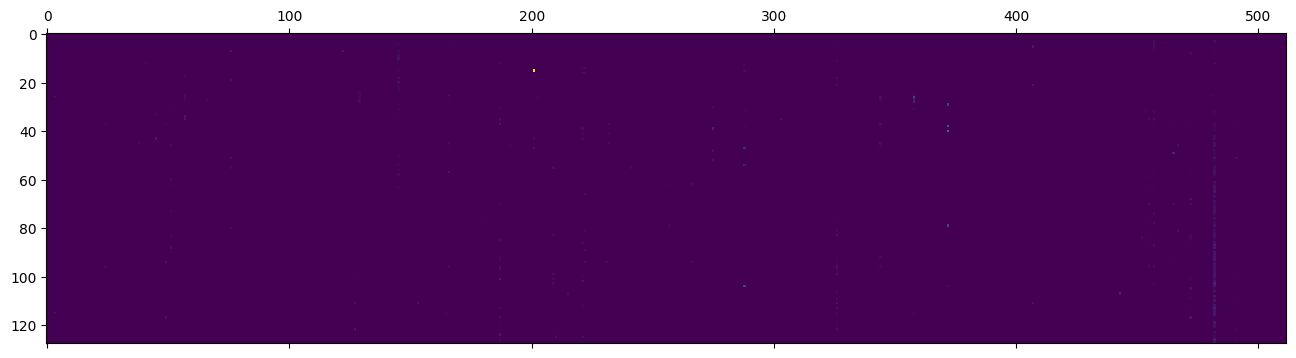

In [9]:
# Let's try to visualize one SAE output - first 512 activations of the first batch element

plt.matshow(sae(cache_batch["blocks.0.mlp.hook_post"])[2].detach().cpu().numpy()[0, :, :512])

In [10]:
# Verify we can get logits from activations


def get_logits(model, cache):
    mlp_w = model.state_dict()["blocks.0.mlp.W_out"]
    mlp_b = model.state_dict()["blocks.0.mlp.b_out"]
    mlp_out = cache["blocks.0.mlp.hook_post"] @ mlp_w + mlp_b
    residual = cache["blocks.0.hook_resid_mid"]

    return model.unembed(model.ln_final(mlp_out + residual))


assert torch.isclose(get_logits(model, cache_batch), logits_batch).all()

## Loop through data, stash values

In [111]:
# Ensure we don't clobber anything
# if False:
if True:
    # First, ensure target paths are empty
    # paths = [os.path.join(DD, f) for f in ["inputs", "activations", "features", "logits", "activations_r"]]
    # paths = [os.path.join(DD, f) for f in ["activations", "features"]]
    paths = [os.path.join(DD, f) for f in ["features"]]
    for path in paths:
        if os.path.exists(path):
            for f in os.listdir(path):
                os.remove(os.path.join(path, f))
            os.rmdir(path)
        os.mkdir(path)

    for i, batch in enumerate(tqdm(data.split(BATCH_SIZE))):
        # Run model
        logits_batch, cache_batch = model.run_with_cache(
            batch,
        )

        # Get activations
        activations_batch = cache_batch["blocks.0.mlp.hook_post"]

        # Get SAE features, reconstructed activations, reconstructed logits
        _, activations_r_batch, features_batch, _, _ = sae(activations_batch)
        features_batch = features_batch.to_sparse()

        # Save everything
        # for x, path in zip([batch, activations_batch, features_batch, logits_batch, activations_r_batch], paths):
        # for x, path in zip([activations_batch, features_batch], paths):
        for x, path in zip([features_batch], paths):
            torch.save(x, os.path.join(path, f"{i}.pt"))

  0%|          | 0/1683 [00:00<?, ?it/s]

100%|██████████| 1683/1683 [06:14<00:00,  4.49it/s]


In [12]:
# Free up some memory
try:
    del batch, cache_batch, activations_batch, features_batch, logits_batch, activations_r_batch
except:
    pass

## Compute per-feature activations

In [13]:
import os
import torch
import pickle
from tqdm import tqdm

# This is kind of a crazy way to do this, but because of memory constraints I'm just gonna do it...

feature_files = os.listdir(os.path.join(DD, "features"))
feature_dim = torch.load(os.path.join(DD, "features", feature_files[0])).shape[-1]
n_files = len(feature_files)
print(f"Number of features: {feature_dim}, number of files: {n_files}")

# Split feature_files into chunks, again for memory reasons
CHUNKS = 6
feature_files = [feature_files[i : i + n_files // CHUNKS] for i in range(0, n_files, n_files // CHUNKS)]

# # Create activation_vectors directory
# if os.path.exists(os.path.join(DD, "feature_vectors")):
#     for f in os.listdir(os.path.join(DD, "feature_vectors")):
#         os.remove(os.path.join(DD, "feature_vectors", f))
#     os.rmdir(os.path.join(DD, "feature_vectors"))
# os.mkdir(os.path.join(DD, "feature_vectors"))

# Accumulate feature vectors in list
with torch.no_grad():
    for k, files_batch in enumerate(feature_files):
        all_features = [[] for _ in range(feature_dim)]
        for i, file in enumerate(tqdm(files_batch)):
            feature = torch.load(os.path.join(DD, "features", file)).to_dense()  # .cpu()
            for j in range(feature_dim):
                all_features[j].append(feature[:, :, j].to_sparse())

        # Basic save
        with open(os.path.join(DD, f"all_features_vectors_{k}.pkl"), "wb") as f:
            pickle.dump(all_features, f)

        # Save feature vectors individually
        for j in range(feature_dim):
            torch.save(torch.cat(all_features[j]), os.path.join(DD, "feature_vectors", f"{j}_{k}.pt"))

        # Free up some memory
        try:
            del all_features
        except:
            pass

Number of features: 16384, number of files: 1683


100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


In [17]:
# Merge feature vectors
os.mkdir(os.path.join(DD, "feature_vectors_merged"))

for i in tqdm(range(feature_dim)):
    feature_merged = torch.cat(
        [torch.load(os.path.join(DD, "feature_vectors", f"{i}_{k}.pt")) for k in range(CHUNKS + 1)]
    )
    torch.save(feature_merged, os.path.join(DD, "feature_vectors_merged", f"{i}_full.pt"))

  0%|          | 0/16384 [00:00<?, ?it/s]

100%|██████████| 16384/16384 [08:33<00:00, 31.89it/s] 


In [19]:
# Verify that shapes are correct

feature_merged = torch.load(os.path.join(DD, "feature_vectors_merged", "0_full.pt"))
print(feature_merged.shape)  # Should be (n_samples, n_tokens)
print(len(data))

torch.Size([215402, 128])
215402


## Get (feature, token) pairs; audit for predictive accuracy

In [109]:
# Find (activation, feature pairs)

# Find the top K activations for each feature
# Count tokens in top-K activating examples

TOP_K = 100
feature_top_tokens = pd.DataFrame(index=range(feature_dim), columns=["token_idx", "token_str", "count"])

for i in tqdm(range(feature_dim)):
    # Load feature as an (n_samples, n_tokens) matrix
    feature = torch.load(os.path.join(DD, "feature_vectors_merged", f"{i}_full.pt")).to_dense()

    # Get top K activations using a flat view into the feature
    feature_flat = feature.view(-1)
    topk_vals, indices_flat = torch.topk(feature_flat, TOP_K, largest=True)

    # Reshape indices to 2-D
    n, m = feature.shape
    r, c = indices_flat // m, indices_flat % m
    idx = torch.stack([r, c], dim=1)

    # What are the tokens?
    feature_tokens = data[idx[:, 0], idx[:, 1]]
    token_counts = torch.bincount(feature_tokens, minlength=len(model.tokenizer))
    top_token = torch.argmax(token_counts).item()

    # Save to dataframe
    feature_top_tokens.loc[i] = [top_token, model.to_single_str_token(top_token), token_counts[top_token].item()]

feature_top_tokens.to_csv(os.path.join(DD, "feature_top_tokens.csv"))
feature_top_tokens

  0%|          | 0/16384 [00:00<?, ?it/s]

100%|██████████| 16384/16384 [03:34<00:00, 76.25it/s] 


,token_idx,token_str,count
0,248,a,19
1,191,\r,14
2,191,\r,9
3,17371,utf,100
4,191,\r,12
...,...,...,...
16379,191,\r,13
16380,19,1,100
16381,286,and,100
16382,8461,spr,59


In [143]:
# Get precision, recall, F1 for naive prediction: top token -> feature fires

top_token_audit = pd.DataFrame(index=range(feature_dim), columns=["top_token", "precision", "recall", "f1"])

for i in tqdm(range(feature_dim)):
    top_token = feature_top_tokens.loc[i, "token_idx"]
    feature = torch.load(os.path.join(DD, "feature_vectors_merged", f"{i}_full.pt")).to_dense()

    # n_correct = 0
    # for j in range(len(data)):
    #     for k in range(len(data[j])):
    #         if (data[j, k] == top_token and feature[j, k] > 0) or (data[j, k] != top_token and feature[j, k] == 0):
    #             n_correct += 1

    bool1 = data == top_token
    bool2 = feature > 0

    # n_correct = ((bool1 & bool2) | (~bool1 & ~bool2)).sum().item()
    tp = (bool1 & bool2).sum().item()
    fp = (~bool1 & bool2).sum().item()
    fn = (bool1 & ~bool2).sum().item()
    tn = (~bool1 & ~bool2).sum().item()

    p = tp / (tp + fp)
    r = tp / (tp + fn)
    f1 = 2 * p * r / (p + r)

    top_token_audit.loc[i] = [top_token, p, r, f1]

top_token_audit.to_csv(os.path.join(DD, "top_token_audit.csv"))
top_token_audit

  0%|          | 0/16384 [00:00<?, ?it/s]

100%|██████████| 16384/16384 [03:51<00:00, 70.88it/s] 


,top_token,precision,recall,f1
0,248,0.129994,0.001661,0.003281
1,191,0.031985,0.008611,0.013569
2,191,0.020802,0.007262,0.010766
3,17371,0.013031,1.0,0.025727
4,191,0.031208,0.004876,0.008434
...,...,...,...,...
16379,191,0.022464,0.006432,0.010001
16380,19,0.662478,0.600608,0.630028
16381,286,0.435758,0.3408,0.382474
16382,8461,0.003102,1.0,0.006184


In [148]:
pd.merge(feature_top_tokens, top_token_audit, left_index=True, right_index=True).drop(
    columns=["top_token"]
).sort_values("f1", ascending=False).to_csv(os.path.join(DD, "top_token_audit_merged.csv"))